# Intro
In this analysis we ale looking at the number of participants in each Liquidity Pool (LP) on Loop Finance in order to spot any pools that might be more dependent on whales.

## Data
The data for this analysis comes from two sources:
- Pool liquidity data was queried through Loop Finance's [GraphQL API](https://graphql.loop.markets/graphql).
- Pool participants data was queried through [FlipsideCrypto](https://app.flipsidecrypto.com/velocity/queries/f9ba1281-673e-4010-9e74-315bfd094cad) and exported through their API.

## Importing modules and data
In the code block below we are going to import the modules needed to fetch, handle and analyze the data.

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
import requests

First we are going to use the Loop Finance GraphQL API to get a list of all Liquidity Pools and the contract address of its tokens.

In [105]:
url = 'https://graphql.loop.markets/graphql'
headers = {'Accept-Encoding': 'gzip, deflate, br','Content-Type': 'application/json','Accept': 'application/json','Connection': 'keep-alive','DNT': '1','Origin': 'https://graphql.loop.markets'}
transport = AIOHTTPTransport(url=url, headers=headers)
client = Client(transport=transport)

query_ListedPairs = gql(
    '''query pairs {
  ListedPairs {
    address
    token
    pair_with_token
  }
}'''
)
response_ListedPairs = await client.execute_async(query_ListedPairs)

df_ListedPairs = pd.json_normalize(response_ListedPairs['ListedPairs'])
df_ListedPairs.drop_duplicates(subset=['address'],keep='first',inplace=True,ignore_index=True)
df_ListedPairs.rename(columns={'address':'lp_address'},inplace=True)
df_ListedPairs.head()

,lp_address,token,pair_with_token
0,terra1dw5j23l6nwge69z0enemutfmyc93c36aqnzjj5,terra1jx4lmmke2srcvpjeereetc9hgegp4g5j0p9r2q,uusd
1,terra106a00unep7pvwvcck4wylt4fffjhgkf9a0u6eu,terra1nef5jf6c7js9x6gkntlehgywvjlpytm7pcgkn4,uusd
2,terra154jt8ppucvvakvqa5fyfjdflsu6v83j4ckjfq3,terra1nef5jf6c7js9x6gkntlehgywvjlpytm7pcgkn4,terra1jx4lmmke2srcvpjeereetc9hgegp4g5j0p9r2q
3,terra13eggta6zqfg03mxgqg9p5paqka7tgaaxnkhuuu,uusd,terra1kcthelkax4j9x8d3ny6sdag0qmxxynl3qtcrpy
4,terra15568nqrqcawm263yqcuuuvj5mh763tp8jyscq3,terra1ez46kxtulsdv07538fh5ra5xj8l68mu8eg24vr,uusd


Then we loop through the list to build another query that will return the Liquidity (TVL) of each pool.

In [106]:
pairs = list(zip(df_ListedPairs.token,df_ListedPairs.pair_with_token))

liq = []
for pair in pairs:
  query_TVL = gql(
      ('query tvl {tokenTotalLockedValue (second_token: "') + pair[0] + ('" token: "') + pair[1] + ('") {liquidity}}')
  )
  response_TVL = await client.execute_async(query_TVL)
  liq.append(int(response_TVL['tokenTotalLockedValue']['liquidity']))

liq_converted = [x/10**6 for x in liq]

df_ListedPairs['tvl'] = liq_converted
df_ListedPairs.head()

,lp_address,token,pair_with_token,tvl
0,terra1dw5j23l6nwge69z0enemutfmyc93c36aqnzjj5,terra1jx4lmmke2srcvpjeereetc9hgegp4g5j0p9r2q,uusd,3.435175e+05
1,terra106a00unep7pvwvcck4wylt4fffjhgkf9a0u6eu,terra1nef5jf6c7js9x6gkntlehgywvjlpytm7pcgkn4,uusd,2.730958e+06
2,terra154jt8ppucvvakvqa5fyfjdflsu6v83j4ckjfq3,terra1nef5jf6c7js9x6gkntlehgywvjlpytm7pcgkn4,terra1jx4lmmke2srcvpjeereetc9hgegp4g5j0p9r2q,2.205749e+06
3,terra13eggta6zqfg03mxgqg9p5paqka7tgaaxnkhuuu,uusd,terra1kcthelkax4j9x8d3ny6sdag0qmxxynl3qtcrpy,1.092899e+05
4,terra15568nqrqcawm263yqcuuuvj5mh763tp8jyscq3,terra1ez46kxtulsdv07538fh5ra5xj8l68mu8eg24vr,uusd,1.691849e+04


In [107]:
flip_api = requests.get('https://api.flipsidecrypto.com/api/v2/queries/f9ba1281-673e-4010-9e74-315bfd094cad/data/latest').text

providers_flip = pd.read_json(flip_api).drop(columns=['PROVIDED_LP_TOKENS','WITHDRAWN_LP_TOKENS','BALANCE'])
providers_flip.columns = [x.lower() for x in providers_flip.columns]
providers_flip.rename(columns={'provider':'providers'},inplace=True)
providers = providers_flip.groupby(by=['lp_address','lp']).count().reset_index()
providers.head()

,lp_address,lp,providers
0,terra106a00unep7pvwvcck4wylt4fffjhgkf9a0u6eu,loop-ust,17803
1,terra10s94a5gesvayqlekgn570r3nsnmr8q7lf5zkjp,loop-whmim,6
2,terra123neekasfmvcs4wa70cgw3j3uvwzqacdz2we03,aust-ust,1686
3,terra12aazc56hv7aj2fcvmhuxve0l4pmayhpn794m0p,loop-halo,154
4,terra13ay3hftcft25uazl76q8gmdk993y9nyv9avu2h,loop-mir,255


Once we have the environment ready, we can import the two datasets and load them as Pandas Dataframes. The two datasets are then merged together on the Liquidity Pool ('lp_address') column and ordered by their USD Liquidity value.

In [108]:
df = pd.merge(df_ListedPairs,providers,on=['lp_address'])\
    .sort_values(by=['tvl'],ascending=False)\
    .reset_index()\
    .drop(['index'],axis=1)
df.head()

,lp_address,token,pair_with_token,tvl,lp,providers
0,terra1v93ll6kqp33unukuwls3pslquehnazudu653au,terra1kc87mu460fwkqte29rquh4hc20m54fxwtsx7gp,uluna,1.643598e+07,bluna-luna,1745
1,terra123neekasfmvcs4wa70cgw3j3uvwzqacdz2we03,terra1hzh9vpxhsk8253se0vv5jj6etdvxu3nv8z07zu,uusd,1.100597e+07,aust-ust,1686
2,terra1sgu6yca6yjk0a34l86u6ju4apjcd6refwuhgzv,uluna,uusd,7.576565e+06,luna-ust,1068
3,terra16j5f4lp4z8dddm3rhyw8stwrktyhcsc8ll6xtt,uluna,terra1hzh9vpxhsk8253se0vv5jj6etdvxu3nv8z07zu,5.366786e+06,luna-aust,581
4,terra1f6d3pggq7h2y7jrgwxp3xh08yhvj8znalql87h,terra14z56l0fp2lsf86zy3hty2z47ezkhnthtr9yq76,uusd,2.858424e+06,anc-ust,1107


As we can see in the table and the plot below, the USD value varies greatly, from just a few thousand dollars to over $16M, so in order to better visualize each pool, we will split them into tiers.

In [109]:
df[['tvl','providers']].describe()

,tvl,providers
count,3.700000e+01,37.000000
mean,1.546345e+06,959.270270
std,3.422082e+06,2927.090892
min,4.044999e+03,6.000000
25%,3.435556e+04,38.000000
50%,1.421480e+05,228.000000
75%,1.115131e+06,664.000000
max,1.643598e+07,17803.000000


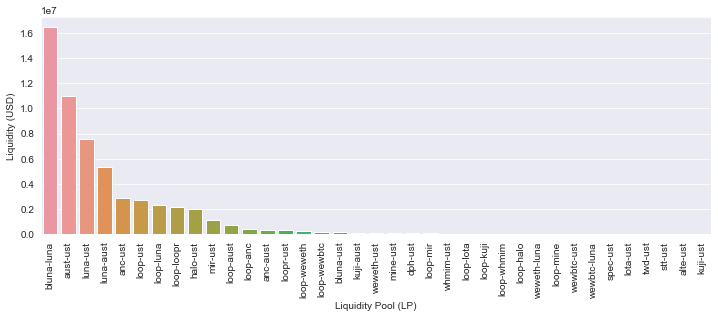

In [110]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))

ax = plt.subplot()
sns.barplot(data=df,x='lp',y='tvl')
plt.xticks(rotation=90)
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Liquidity (USD)')
plt.show()

In [111]:
tier1 = df[0:3].reset_index()
tier2 = df[3:13].reset_index()
tier3 = df[13:].reset_index()

Now we can create plots for each tier. On the X axis we will have each LP, the Y axis represents the Liquidity of the pool in USD, and each bar has the number of providers on it.

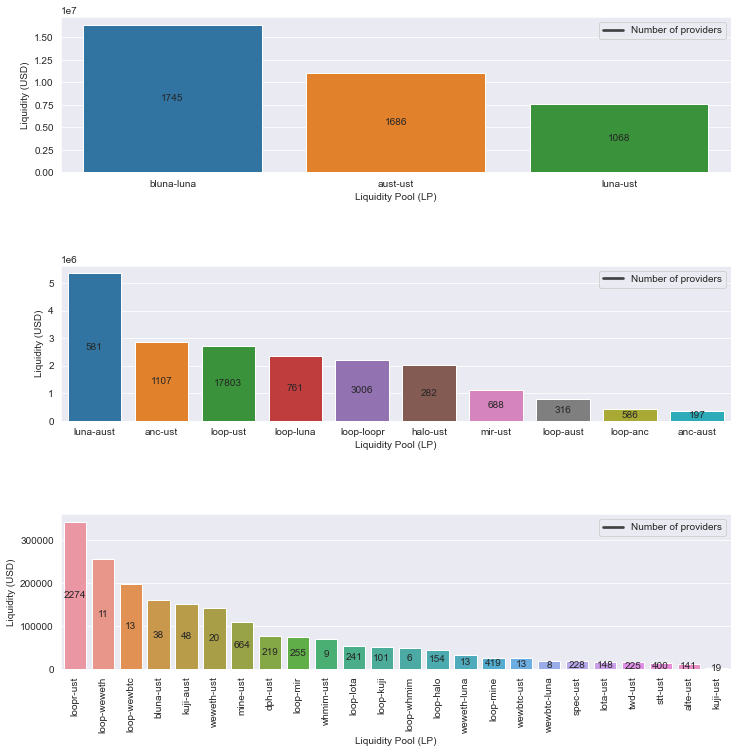

In [112]:
plt.figure(figsize=(12,12))

ax1 = plt.subplot(3,1,1)
t1 = sns.barplot(data=tier1,x='lp',y='tvl')
# plt.xticks(rotation=90)
plt.bar_label(t1.containers[0],labels=tier1.providers,label_type='center')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Liquidity (USD)')
plt.legend(['Number of providers'])

ax2 = plt.subplot(3,1,2)
t2 = sns.barplot(data=tier2,x='lp',y='tvl')
# plt.xticks(rotation=90)
plt.bar_label(t2.containers[0],labels=tier2.providers,label_type='center')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Liquidity (USD)')
plt.legend(['Number of providers'])

ax3 = plt.subplot(3,1,3)
t3 = sns.barplot(data=tier3,x='lp',y='tvl')
plt.xticks(rotation=90)
plt.bar_label(t3.containers[0],labels=tier3.providers,label_type='center')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Liquidity (USD)')
plt.legend(['Number of providers'])

plt.subplots_adjust(hspace=0.6)
plt.show()

While most pools definitely have a healthy amount of providers participating in them, a few others are depending on just a handful of providers. The clear outlier here is the loop-ust (`terra106a00unep7pvwvcck4wylt4fffjhgkf9a0u6eu`) pool that has 17803 providers.

On the other hand you have pools with less than 10 providers, such as whmim-ust (`terra1me6a35xuzf9ycjaaqyj7798g5tewunp6dzg27e`), loop-whmim (`terra10s94a5gesvayqlekgn570r3nsnmr8q7lf5zkjp`) and wewbtc-ust (`terra17e0aslpj3rrt62gwh7utj3fayas4h8dl3y8ju3`).

Below we can see the distribution of these numbers and in order to remove the distortion cause by the outlier mentioned above, a secondary, zoomed-in plot in available alongside it.

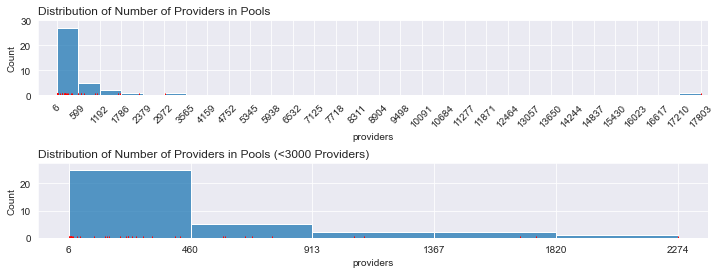

In [113]:
plt.figure(figsize=(12,4))

min_val = df.providers.min()
max_val = df.providers.max()
val_width = max_val - min_val
n_bins = 30
bin_width = val_width/n_bins

ax1 = plt.subplot(2,1,1)
sns.histplot(data=df,x='providers',bins=n_bins,binrange=(min_val,max_val))
plt.xticks(np.arange(min_val-bin_width,max_val+bin_width,bin_width),rotation=45)
ax1.axis([-500,18000,0,30])
sns.rugplot(data=df,x='providers',color='r')
plt.title('Distribution of Number of Providers in Pools',loc='left')

ax2 = plt.subplot(2,1,2)

min_val = df.providers.min()
max_val = df[df.providers < 3000].providers.max()
val_width = max_val - min_val
n_bins = 5
bin_width = val_width/n_bins

sns.histplot(data=df[df.providers < 3000],x='providers',multiple='stack',bins=n_bins,binrange=(min_val,max_val))
plt.xticks(np.arange(min_val-bin_width, max_val+bin_width, bin_width))
sns.rugplot(data=df[df.providers < 3000],x='providers',color='r')
plt.title('Distribution of Number of Providers in Pools (<3000 Providers)',loc='left')

plt.subplots_adjust(hspace=0.9)
plt.show()